# Final Project DS301 (Gavin Yang, Jerry Meng)


## Dataset and Preprocessing

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import random_split
import seaborn as sns
from sklearn.metrics import f1_score

In [2]:
train_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])

test_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [3]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

def is_grayscale(img):
    """Check if the PIL Image is grayscale."""
    if img.mode != 'RGB':
        return True
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b:
                return False
    return True

In [4]:
train_dataset_cifar10 = torchvision.datasets.CIFAR10(root='.', train=True, transform=train_transformer, download=True)
test_dataset_cifar10 = torchvision.datasets.CIFAR10(root='.', train=False, transform=test_transformer, download=True)
train_dataset_fixed_cifar10 = torchvision.datasets.CIFAR10(root='.', train=True, transform=test_transformer, download=True)

caltech101 = torchvision.datasets.Caltech101(root='.', download=True)
filtered_data = [(img, label) for img, label in caltech101 if not is_grayscale(img)]
caltech101 = CustomDataset(filtered_data)
train_size = int(0.8 * len(caltech101))
test_size = len(caltech101) - train_size
train_dataset, test_dataset = random_split(caltech101, [train_size, test_size])

train_dataset_caltech101 = CustomDataset(train_dataset, transform=train_transformer)
test_dataset_caltech101 = CustomDataset(test_dataset, transform=test_transformer)
train_dataset_fixed_caltech101 = CustomDataset(train_dataset, transform=test_transformer)

train_dataset_flower = torchvision.datasets.Flowers102(root='.', split='train', transform=train_transformer, download=True)
test_dataset_flower = torchvision.datasets.Flowers102(root='.', split='test', transform=test_transformer, download=True)
train_dataset_fixed_flower = torchvision.datasets.Flowers102(root='.', split='train', transform=test_transformer, download=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13220322.69it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified


131740031it [00:03, 41416146.20it/s]


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


14028800it [00:00, 36316817.18it/s]


Extracting ./caltech101/Annotations.tar to ./caltech101


100%|██████████| 344862509/344862509 [00:20<00:00, 16924105.38it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 670767.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 18170064.35it/s]


In [5]:
def to_loader(batch_size, train_dataset, test_dataset, train_dataset_fixed):
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  train_dataloader_fixed = torch.utils.data.DataLoader(train_dataset_fixed, shuffle=False, batch_size=batch_size, drop_last=True)
  return train_dataloader, test_dataloader, train_dataloader_fixed

## Training and Eval Function

In [6]:
def adjust_input_for_model(model, inputs):

    # Check for LSTM types
    if isinstance(model, LSTMModel): #  or \
      #  isinstance(model, PositionalEmbedding) or \
      #  isinstance(model, ChannelEmbedding) or \
      #  isinstance(model, SinusoidalPositionalEmbedding):
        return inputs.view(inputs.size(0), inputs.size(2), -1)

    return inputs

def batch_gd(model, criterion, optimizer, train_loader, epochs):
    train_losses = np.zeros(epochs)

    for i in range(epochs):
        model.train()
        start_time = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Adjust inputs for model
            inputs = adjust_input_for_model(model, inputs)
            inputs, targets = inputs.to(device), targets.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        train_losses[i] = train_loss

        duration = datetime.now() - start_time

        print(f"Epoch: {i+1}/{epochs}, Train loss: {train_loss:.4f}")
        print(f"Duration: {duration}\n")

    return train_losses

In [7]:
def evaluate(model, train_loader_fixed, test_dataloader):
  model.eval()
  n_correct = 0
  n_total = 0

  for inputs, targets in train_loader_fixed:
      inputs = adjust_input_for_model(model, inputs)
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      _, preds = torch.max(outputs, 1)

      n_correct += (preds == targets).sum().item()
      n_total += targets.shape[0]

  train_acc = n_correct/n_total

  n_correct = 0
  n_total = 0
  target = []
  pred = []

  for inputs, targets in test_dataloader:
      target.extend(targets.tolist())
      inputs = adjust_input_for_model(model, inputs)
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      _, preds = torch.max(outputs, 1)
      pred.extend(preds.tolist())

      n_correct += (preds == targets).sum().item()
      n_total += targets.shape[0]

  test_acc = n_correct/n_total

  test_f1 = f1_score(target, pred, average="macro", zero_division=0.0)


  return train_acc, test_acc, test_f1

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def train_eval(model_func, **kwargs):
  batch_size = 128
  test_acc_lst = []
  test_f1_lst = []
  for dataset in ["cifar", "caltech", "food"]:
    if dataset == "cifar":
      train_dataloader, test_dataloader, train_dataloader_fixed = to_loader(batch_size, train_dataset_cifar10, test_dataset_cifar10, train_dataset_fixed_cifar10)
      num_classes = 10
    elif dataset == "caltech":
      train_dataloader, test_dataloader, train_dataloader_fixed = to_loader(batch_size, train_dataset_caltech101, test_dataset_caltech101, train_dataset_fixed_caltech101)
      num_classes = 101
    elif dataset == "food":
      train_dataloader, test_dataloader, train_dataloader_fixed = to_loader(batch_size, train_dataset_flower, test_dataset_flower, train_dataset_fixed_flower)
      num_classes = 1000

    model = model_func(num_classes=num_classes, **kwargs)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = batch_gd(model, criterion, optimizer, train_dataloader, 10)
    train_acc, test_acc, test_f1 = evaluate(model, train_dataloader_fixed, test_dataloader)
    print("On " + dataset, f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}, Test Macro F1: {test_f1:.4f}\n")
    test_acc_lst.append(test_acc)
    test_f1_lst.append(test_f1)

  return test_acc_lst, test_f1_lst

In [10]:
# dict to store all results
result_acc = {}
result_f1 = {}

## CNN and LSTM Baseline Model

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 36, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Conv2d(36, 36, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(36*8*8, 512)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM network
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

In [13]:
result_acc["cnn"], result_f1["cnn"] = train_eval(CNN)

Epoch: 1/10, Train loss: 1.7844
Duration: 0:00:27.685858

Epoch: 2/10, Train loss: 1.4656
Duration: 0:00:20.276498

Epoch: 3/10, Train loss: 1.3510
Duration: 0:00:20.332439

Epoch: 4/10, Train loss: 1.2849
Duration: 0:00:20.261877

Epoch: 5/10, Train loss: 1.2322
Duration: 0:00:20.262647

Epoch: 6/10, Train loss: 1.1842
Duration: 0:00:20.285981

Epoch: 7/10, Train loss: 1.1494
Duration: 0:00:20.368052

Epoch: 8/10, Train loss: 1.1229
Duration: 0:00:20.311718

Epoch: 9/10, Train loss: 1.0936
Duration: 0:00:20.366021

Epoch: 10/10, Train loss: 1.0748
Duration: 0:00:20.429453

On cifar Train accuracy: 0.6762, Test accuracy: 0.6656, Test Macro F1: 0.6651

Epoch: 1/10, Train loss: 4.0656
Duration: 0:00:04.609784

Epoch: 2/10, Train loss: 3.2413
Duration: 0:00:04.587683

Epoch: 3/10, Train loss: 2.9879
Duration: 0:00:04.601310

Epoch: 4/10, Train loss: 2.8206
Duration: 0:00:04.589838

Epoch: 5/10, Train loss: 2.6557
Duration: 0:00:04.612991

Epoch: 6/10, Train loss: 2.5454
Duration: 0:00:04.

In [14]:
# Hyperparameters
input_size = 32 * 3  # num of channels * height (32) of each row
hidden_size = 512
num_layers = 1

result_acc["lstm"], result_f1["lstm"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

Epoch: 1/10, Train loss: 2.0381
Duration: 0:00:21.380823

Epoch: 2/10, Train loss: 1.8948
Duration: 0:00:20.481817

Epoch: 3/10, Train loss: 1.8019
Duration: 0:00:20.433260

Epoch: 4/10, Train loss: 1.7098
Duration: 0:00:20.476259

Epoch: 5/10, Train loss: 1.6360
Duration: 0:00:20.496769

Epoch: 6/10, Train loss: 1.5774
Duration: 0:00:20.467516

Epoch: 7/10, Train loss: 1.5332
Duration: 0:00:20.375969

Epoch: 8/10, Train loss: 1.4984
Duration: 0:00:20.417164

Epoch: 9/10, Train loss: 1.4637
Duration: 0:00:20.451578

Epoch: 10/10, Train loss: 1.4346
Duration: 0:00:20.388784

On cifar Train accuracy: 0.4959, Test accuracy: 0.4848, Test Macro F1: 0.4784

Epoch: 1/10, Train loss: 4.1464
Duration: 0:00:04.617198

Epoch: 2/10, Train loss: 3.9596
Duration: 0:00:04.592927

Epoch: 3/10, Train loss: 3.7989
Duration: 0:00:04.594049

Epoch: 4/10, Train loss: 3.6522
Duration: 0:00:04.572320

Epoch: 5/10, Train loss: 3.5417
Duration: 0:00:04.578969

Epoch: 6/10, Train loss: 3.4382
Duration: 0:00:04.

## LSTM Model with Postional and Channel Embeddings

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 use_positional=False, use_channel=False, use_sinusoidal=False, sequence_length=None):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_positional = use_positional
        self.use_channel = use_channel
        self.use_sinusoidal = use_sinusoidal

        if self.use_positional:
            self.positional_embedding = PositionalEmbedding(sequence_length=sequence_length, input_size=input_size)

        if self.use_channel:
            self.channel_embedding = ChannelEmbedding(sequence_length=sequence_length, input_size=input_size)

        if self.use_sinusoidal:
            self.sinusoidal_embedding = SinusoidalPositionalEmbedding(sequence_length=sequence_length, input_size=input_size)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        if self.use_positional:
            x = self.positional_embedding(x)

        if self.use_channel:
            x = self.channel_embedding(x)

        if self.use_sinusoidal:
            x = self.sinusoidal_embedding(x)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

In [16]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, input_size):
        super(PositionalEmbedding, self).__init__()

        # Ensure input_size is divisible by 3 for RGB channels
        per_channel_size = input_size // 3

        # Create a tensor with values linearly spaced between 1 and 2 for one channel
        channel_embedding = torch.linspace(1.0, 2.0, per_channel_size)

        # Duplicate for RGB channels
        full_embedding = torch.cat([channel_embedding for _ in range(3)]).unsqueeze(0)

        # Repeat this pattern for every position in the sequence
        pe = full_embedding.repeat(sequence_length, 1).unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add the positional encoding to every batch in x
        x = x + self.pe
        return x

In [17]:
class ChannelEmbedding(nn.Module):
    def __init__(self, sequence_length, input_size):
        super(ChannelEmbedding, self).__init__()

        ce = torch.tensor([2.0] * (input_size // 3) + [2.5] * (input_size // 3) + [3.0] * (input_size // 3))

        # We don't need to repeat for the batch size. Instead, broadcast will handle it.
        ce = ce.unsqueeze(0).repeat(sequence_length, 1).unsqueeze(0)

        self.register_buffer('ce', ce)

    def forward(self, x):
        x = x + self.ce
        return x

In [18]:
#For LSTM with Positional embedding
result_acc["lstm_pos"], result_f1["lstm_pos"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, use_positional=True, sequence_length=32)

Epoch: 1/10, Train loss: 2.2520
Duration: 0:00:20.416500

Epoch: 2/10, Train loss: 2.0824
Duration: 0:00:20.315812

Epoch: 3/10, Train loss: 2.0498
Duration: 0:00:20.443017

Epoch: 4/10, Train loss: 2.0198
Duration: 0:00:20.415687

Epoch: 5/10, Train loss: 1.9892
Duration: 0:00:20.392740

Epoch: 6/10, Train loss: 1.9731
Duration: 0:00:20.371562

Epoch: 7/10, Train loss: 1.9655
Duration: 0:00:20.336270

Epoch: 8/10, Train loss: 1.9548
Duration: 0:00:20.365450

Epoch: 9/10, Train loss: 1.9434
Duration: 0:00:20.406055

Epoch: 10/10, Train loss: 1.9455
Duration: 0:00:20.392161

On cifar Train accuracy: 0.2640, Test accuracy: 0.2682, Test Macro F1: 0.2337

Epoch: 1/10, Train loss: 4.2042
Duration: 0:00:04.611905

Epoch: 2/10, Train loss: 4.1665
Duration: 0:00:04.595479

Epoch: 3/10, Train loss: 4.1471
Duration: 0:00:04.611328

Epoch: 4/10, Train loss: 4.1346
Duration: 0:00:04.603215

Epoch: 5/10, Train loss: 4.1047
Duration: 0:00:04.596347

Epoch: 6/10, Train loss: 4.0737
Duration: 0:00:04.

In [19]:
#For LSTM with Channel embedding
result_acc["lstm_chl"], result_f1["lstm_chl"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, use_channel=True, sequence_length=32)

Epoch: 1/10, Train loss: 2.3043
Duration: 0:00:20.589592

Epoch: 2/10, Train loss: 2.2866
Duration: 0:00:20.434977

Epoch: 3/10, Train loss: 2.1859
Duration: 0:00:20.480691

Epoch: 4/10, Train loss: 2.0871
Duration: 0:00:20.516186

Epoch: 5/10, Train loss: 2.0661
Duration: 0:00:20.465761

Epoch: 6/10, Train loss: 2.0421
Duration: 0:00:20.488117

Epoch: 7/10, Train loss: 2.0336
Duration: 0:00:20.414657

Epoch: 8/10, Train loss: 2.0147
Duration: 0:00:20.484407

Epoch: 9/10, Train loss: 2.0012
Duration: 0:00:20.316887

Epoch: 10/10, Train loss: 1.9964
Duration: 0:00:20.550949

On cifar Train accuracy: 0.2496, Test accuracy: 0.2585, Test Macro F1: 0.2235

Epoch: 1/10, Train loss: 4.2028
Duration: 0:00:04.612588

Epoch: 2/10, Train loss: 4.1671
Duration: 0:00:04.569961

Epoch: 3/10, Train loss: 4.1626
Duration: 0:00:04.619315

Epoch: 4/10, Train loss: 4.1574
Duration: 0:00:04.603049

Epoch: 5/10, Train loss: 4.1535
Duration: 0:00:04.645663

Epoch: 6/10, Train loss: 4.1403
Duration: 0:00:04.

In [20]:
#For LSTM with both embeddings
result_acc["lstm_pos_chl"], result_f1["lstm_pos_chl"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, use_positional=True, use_channel=True, sequence_length=32)

Epoch: 1/10, Train loss: 2.3062
Duration: 0:00:20.538336

Epoch: 2/10, Train loss: 2.3041
Duration: 0:00:20.558301

Epoch: 3/10, Train loss: 2.3039
Duration: 0:00:20.471134

Epoch: 4/10, Train loss: 2.3042
Duration: 0:00:20.577042

Epoch: 5/10, Train loss: 2.3042
Duration: 0:00:20.605015

Epoch: 6/10, Train loss: 2.3018
Duration: 0:00:20.599881

Epoch: 7/10, Train loss: 2.2993
Duration: 0:00:20.600036

Epoch: 8/10, Train loss: 2.2928
Duration: 0:00:20.549271

Epoch: 9/10, Train loss: 2.2767
Duration: 0:00:20.504106

Epoch: 10/10, Train loss: 2.2671
Duration: 0:00:20.502269

On cifar Train accuracy: 0.1441, Test accuracy: 0.1487, Test Macro F1: 0.0766

Epoch: 1/10, Train loss: 4.2128
Duration: 0:00:04.599380

Epoch: 2/10, Train loss: 4.1668
Duration: 0:00:04.621473

Epoch: 3/10, Train loss: 4.1683
Duration: 0:00:04.588221

Epoch: 4/10, Train loss: 4.1663
Duration: 0:00:04.597616

Epoch: 5/10, Train loss: 4.1637
Duration: 0:00:04.586314

Epoch: 6/10, Train loss: 4.1662
Duration: 0:00:04.

## LSTM Model ("Attention Is All You Need")

In [21]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, input_size):
        super(SinusoidalPositionalEmbedding, self).__init__()

        # Compute positional encodings
        position = torch.arange(sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2) * -(np.log(10000.0) / input_size))
        pe = torch.zeros(sequence_length, input_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe
        return x

In [22]:
# For LSTM with the innovative idea in the article "Attention is All You Need"
result_acc["lstm_sin"],result_f1["lstm_sin"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, use_sinusoidal=True, sequence_length=32)

Epoch: 1/10, Train loss: 2.0554
Duration: 0:00:20.682360

Epoch: 2/10, Train loss: 1.9373
Duration: 0:00:20.729595

Epoch: 3/10, Train loss: 1.8290
Duration: 0:00:20.502139

Epoch: 4/10, Train loss: 1.7448
Duration: 0:00:20.566075

Epoch: 5/10, Train loss: 1.6750
Duration: 0:00:20.496912

Epoch: 6/10, Train loss: 1.6187
Duration: 0:00:20.527721

Epoch: 7/10, Train loss: 1.5798
Duration: 0:00:20.497714

Epoch: 8/10, Train loss: 1.5456
Duration: 0:00:20.512149

Epoch: 9/10, Train loss: 1.5178
Duration: 0:00:20.584845

Epoch: 10/10, Train loss: 1.4930
Duration: 0:00:20.650899

On cifar Train accuracy: 0.4824, Test accuracy: 0.4731, Test Macro F1: 0.4648

Epoch: 1/10, Train loss: 4.1804
Duration: 0:00:04.591560

Epoch: 2/10, Train loss: 4.0630
Duration: 0:00:04.574273

Epoch: 3/10, Train loss: 3.9378
Duration: 0:00:04.589970

Epoch: 4/10, Train loss: 3.7999
Duration: 0:00:04.593936

Epoch: 5/10, Train loss: 3.7090
Duration: 0:00:04.581519

Epoch: 6/10, Train loss: 3.5843
Duration: 0:00:04.

In [23]:
# Combined SinusoidalPositionalEmbedding with Channel
result_acc["lstm_sin_chl"], result_f1["lstm_sin_chl"] = train_eval(LSTMModel, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, use_channel=True, use_sinusoidal=True, sequence_length=32)

Epoch: 1/10, Train loss: 2.3051
Duration: 0:00:20.396754

Epoch: 2/10, Train loss: 2.2898
Duration: 0:00:20.383405

Epoch: 3/10, Train loss: 2.2285
Duration: 0:00:20.318421

Epoch: 4/10, Train loss: 2.1637
Duration: 0:00:20.346138

Epoch: 5/10, Train loss: 2.0928
Duration: 0:00:20.399614

Epoch: 6/10, Train loss: 2.0725
Duration: 0:00:20.330956

Epoch: 7/10, Train loss: 2.0568
Duration: 0:00:20.417710

Epoch: 8/10, Train loss: 2.0472
Duration: 0:00:20.366251

Epoch: 9/10, Train loss: 2.0416
Duration: 0:00:20.356437

Epoch: 10/10, Train loss: 2.0257
Duration: 0:00:20.360875

On cifar Train accuracy: 0.2735, Test accuracy: 0.2805, Test Macro F1: 0.2490

Epoch: 1/10, Train loss: 4.2037
Duration: 0:00:04.579808

Epoch: 2/10, Train loss: 4.1707
Duration: 0:00:04.618640

Epoch: 3/10, Train loss: 4.1699
Duration: 0:00:04.584143

Epoch: 4/10, Train loss: 4.1607
Duration: 0:00:04.587502

Epoch: 5/10, Train loss: 4.1592
Duration: 0:00:04.569738

Epoch: 6/10, Train loss: 4.1602
Duration: 0:00:04.

## Results

In [33]:
plt.rcParams.update({'font.size': 16})

In [24]:
result_a = pd.DataFrame(result_acc, index=["cifar", "caltech", "flower"])
result_a

,cnn,lstm,lstm_pos,lstm_chl,lstm_pos_chl,lstm_sin,lstm_sin_chl
cifar,0.665565,0.484776,0.268229,0.258514,0.148738,0.473057,0.280549
caltech,0.504557,0.303385,0.178385,0.136719,0.092448,0.316406,0.133464
flower,0.186523,0.004069,0.011882,0.015299,0.004395,0.006348,0.006185


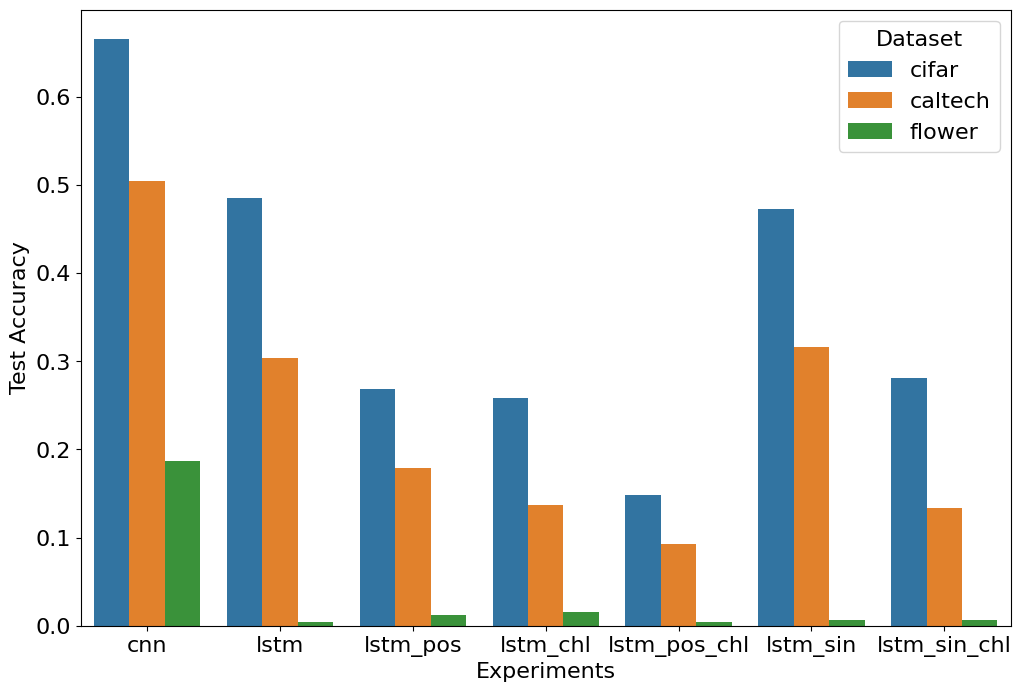

In [34]:
result_ac = result_a.reset_index().melt(id_vars='index')
plt.figure(figsize=(12,8))
sns.barplot(data=result_ac, x='variable', y='value', hue="index")
plt.ylabel("Test Accuracy")
plt.xlabel("Experiments")
plt.legend(title="Dataset")
plt.show()

In [27]:
result_f = pd.DataFrame(result_f1, index=["cifar", "caltech", "flower"])
result_f

,cnn,lstm,lstm_pos,lstm_chl,lstm_pos_chl,lstm_sin,lstm_sin_chl
cifar,0.665132,0.478364,0.233731,0.223501,0.076643,0.464750,0.249025
caltech,0.281229,0.076204,0.012836,0.004689,0.001692,0.072428,0.004799
flower,0.162521,0.000079,0.000230,0.000295,0.000168,0.000124,0.000121


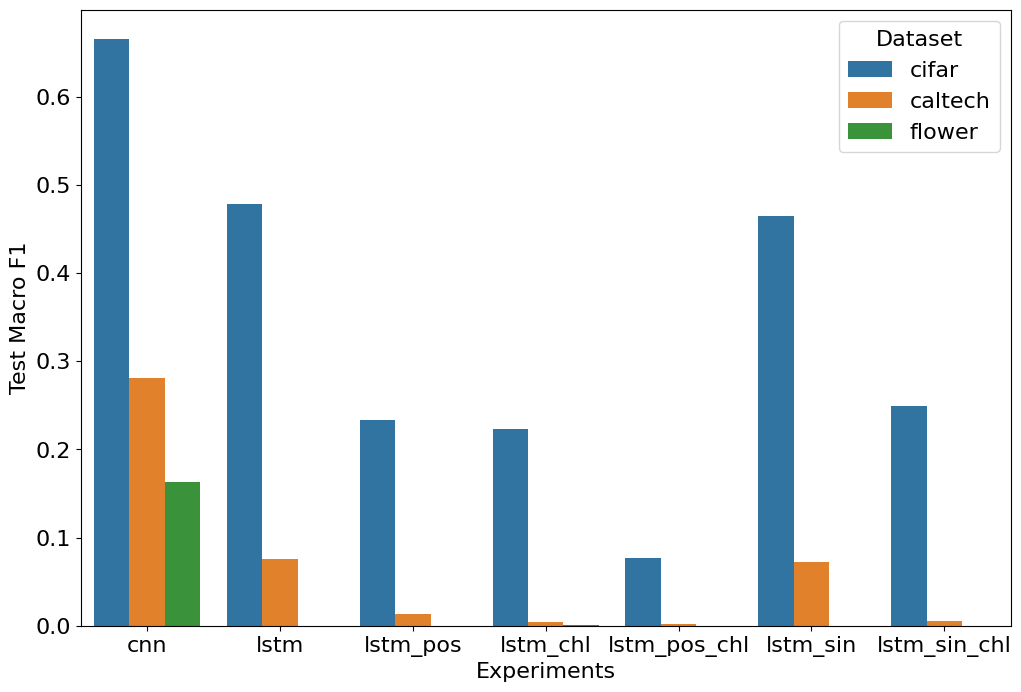

In [35]:
result_ff = result_f.reset_index().melt(id_vars='index')
plt.figure(figsize=(12,8))
sns.barplot(data=result_ff, x='variable', y='value', hue="index")
plt.ylabel("Test Macro F1")
plt.xlabel("Experiments")
plt.legend(title="Dataset")
plt.show()